# Performing Image Processing in SAS DLPy using Image Tables

The following is an image processing example that uses the SAS DLPy API to create and augment image table data sets.

All of the examples use a small toy data set that contains dolphin or giraffe images for the classification tasks. You can download the example image data at https://github.com/sassoftware/python-dlpy/tree/master/dlpy/tests/datasources/giraffe_dolphin_small.

When downloading the data to your computing environment, the folders for the giraffe and dolphin images in the example should be structured as follows:

Giraffe_Dolphin
* Giraffe
    * Giraffe image 1
    * Girrafe image 2
    * ...
* Dolphin
    * Dolphin image 1
    * Dolphin image 2
    * ...       
All of the examples in this notebook require a configured SAS computing environment. This includes SAS CAS (Cloud Analytic Services) server sessions with SAS swat, as well as Python requirements. Example tasks include loading required DLPy functions and a plotting library. 

The example assumes you have an active SAS CAS server.


### Configure Matplotlib and Import SWAT

The following code configures the matplotlib utility to display output in a Jupyter notebook cell and imports SAS SWAT (SAS Wrapper for Analytics Transfer).

In [1]:
%matplotlib inline

import swat

### Configure CAS and Start Session

The following code configures your CAS session.

First, import SWAT. SWAT is a Python interface to SAS CAS that enables you to load data into memory and apply CAS actions to the data.

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.



In [2]:
# You need to specify cashost and casport according to your own cas server.

host_name = 'your-server-name.company.com' # your host name specification will be different
port_number = 5570


# Sess statement invokes SAS SWAT with host and portID specs
sess = swat.CAS(host_name, port_number)


### Import DLPy ImageTable Module

Next, import the DLPy `ImageTable` module. This is a specialized CAS table class that is used for image processing.
You use the DLPy `ImageTable` functions to create and load image tables for analysis.

In [3]:
from dlpy.images import ImageTable

<h3> Specify Path to Images, Name and Load Image Table</h3>


After establishing an active SAS CAS session and importing the SWAT and DLPy modules, load the Dolphin vs. Giraffe images. The collection of DLPy examples all use the same image collection.

Folder Structure for Dolphin vs. Giraffe Images

The folder structure for the giraffe and dolphin images in the example is as follows:

Giraffe_Dolphin
Giraffe
Giraffe image 1
Girrafe image 2
...
Dolphin
Dolphin image 1
Dolphin image 2
...
In the following code, the value for img_path represents a fully-qualified directory path to the images. The path must be accessible by the CAS server session.

In [4]:
img_path='/your/server/path-to/image-directory/giraffe_dolphin_small'

my_images = ImageTable.load_files(sess, path=img_path)


<h3> Verify Images in `my_images` Data Table </h3>

Now we can verify that the `my_images` data table populated. Use the `head()` function to examine the first few rows. 

In [5]:
my_images.head()

Selected Rows from Table IMAGEDATA_CRXKAL

                                             _image_  _label_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x02...  Giraffe   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   

         _filename_0  _id_  
0  giraffe_10022.jpg     1  
1  giraffe_10187.jpg    25  
2  giraffe_10049.jpg    17  
3  giraffe_10069.jpg     3  
4  giraffe_10018.jpg    33

Now you can use `columninfo()` to browse the organization of the image table.

In [6]:
my_images.columninfo()

[ColumnInfo]

         Column Label  ID              Type  RawLength  FormattedLength Format  \
 0      _image_         1  varbinary(image)     912375           912375          
 1      _label_         2           varchar          7                7          
 2  _filename_0         3           varchar         17               17          
 3         _id_         4             int64          8               12          
 
    NFL  NFD  
 0    0    0  
 1    0    0  
 2    0    0  
 3    0    0  

+ Elapsed: 0.000606s, user: 0.000895s, mem: 0.807mb

## Basic ImageTable Functions

Use basic functions from DLPy ImageTable to reveal more information about the images in `my_images`.

<h3> Display Random Images from an Image Data Table</h3>


Now, check some of the images in the data table. Display a table of 8 randomly selected training images from the image table `my_images`. 

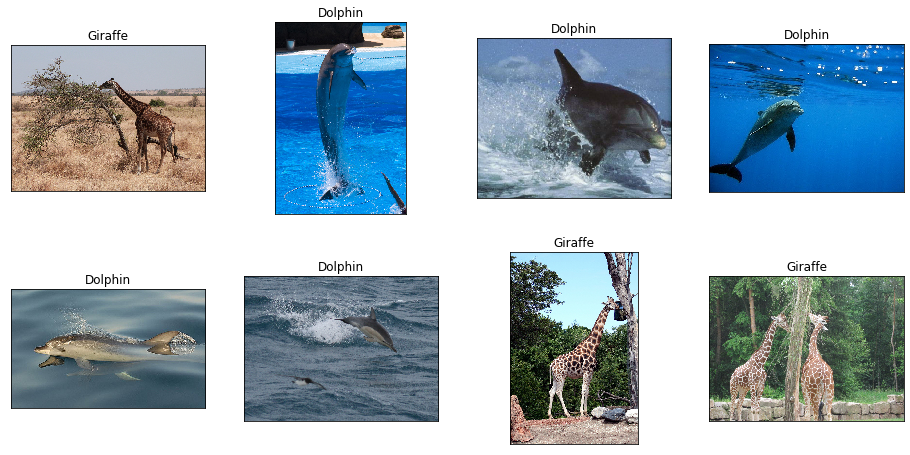

In [7]:
# randomly select 8 images from the table and arrange the display in 4 columns 
my_images.show(nimages=8, ncol=4, randomize=True)

<h3> Summarize Class Label Information in the Image Table </h3>

What is the proportion of dolphin and giraffe images within the image table? Show a frequency analysis of the image table by label values: 


In [8]:
my_images.label_freq

Frequency for IMAGEDATA_CRXKAL

         Level  Frequency
Dolphin      1         49
Giraffe      2         45

The example image table contains 409 images: 237 dolphin images, and 173 giraffe images.

<h3>Summarize the Image Metadata in the Image Table</h3>

Use `image_summary` to display the image metadata in the image table:

In [9]:
my_images.image_summary

jpg                    94
minWidth              400
maxWidth             1024
minHeight             258
maxHeight            1024
meanWidth         904.723
meanHeight        795.436
mean1stChannel    128.505
min1stChannel           0
max1stChannel         255
mean2ndChannel    124.579
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    97.7212
min3rdChannel           0
max3rdChannel         255
dtype: object

The metadata summary shows 94 images of varying sizes, with image widths ranging from 400 to 1024 pixels, and with image heights ranging from 258 to 1024 pixels. This is an example of a table of images that would benefit from image processing. Image processing can standardize all images in the table to a single common image size, which is useful when traiing CNN models.

<h2> Perform Image Processing to Improve CNN Model Performance  </h2>


SAS DLPy lets you do basic image processing such as resizing and cropping.

**Note:** Each image processing function has two modes, specified by the values for the `Inplace` setting:

If `inplace=False`, the function will return a new `ImageTable` that contains the processed images. The original image table will not be modified.

If `inplace=True`, the function will process the images in the table in place. In other words, the image table is modified.


<h3> Image Processing: Resize Images to a Fixed Size</h3>


The image processing task can be a step before model training. The input images may not be all the same size. The following code resizes all images in the table to 128 x 128 pixels.

The following code uses the `inplace=False` setting, so the original table with the different-sized images will remain, and a new table is created where all images are standardized 128 x 128 pixel images.  

Afterwards, check the resized images by displaying 8 random images in a table with 4 columns. 

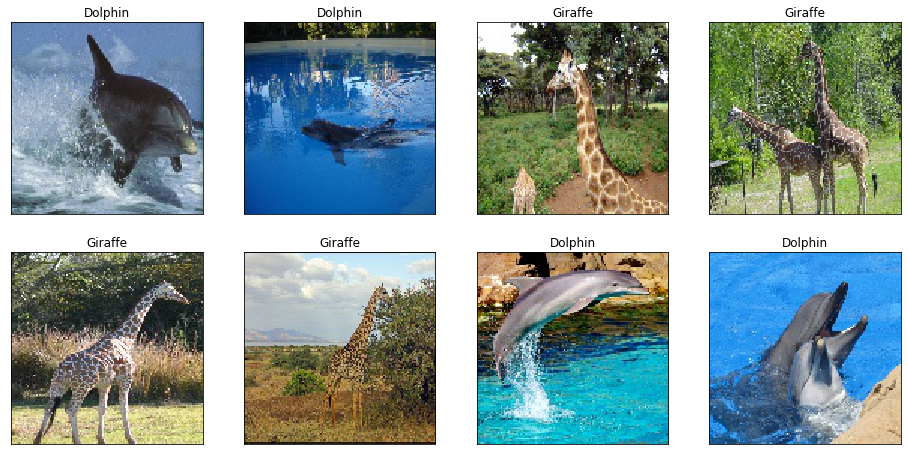

In [10]:
resized_images = my_images.resize(width=128, height=128, inplace=False)
resized_images.show(8,4)

<h4>Summarize the Image Metadata in New Standardized Image Table</h4>

Use `image_summary` to display the image metadata for the new image table with standardized 128 x 128 images:

In [11]:
resized_images.image_summary

jpg                    94
minWidth              128
maxWidth              128
minHeight             128
maxHeight             128
meanWidth             128
meanHeight            128
mean1stChannel    128.436
min1stChannel           0
max1stChannel         255
mean2ndChannel    124.561
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    97.8731
min3rdChannel           0
max3rdChannel         255
dtype: object

We can see that all 94 images in the new table `resized_images` share the same dimensions: 128 px height and 128 px width. What about the original image table? Did image sizes change in `my_images`?

We can find out by using `show()` to display 8 random images from the original image table `my_images` in a table with 4 columns:

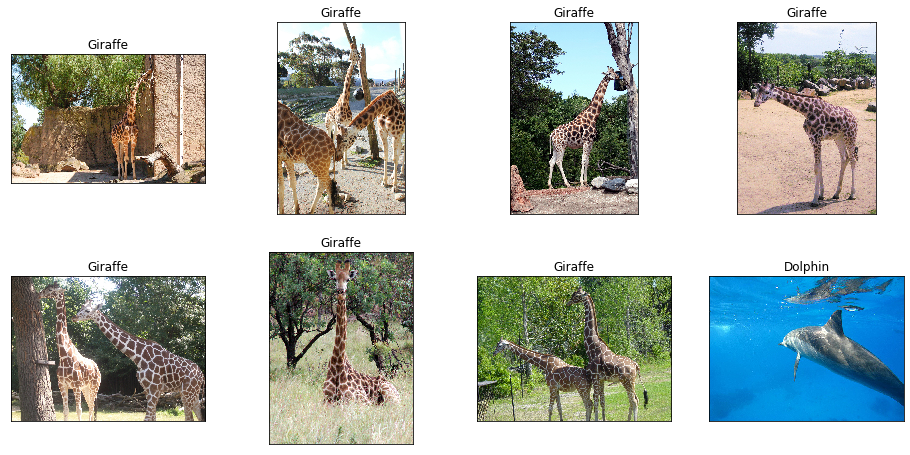

In [12]:
my_images.show(8, 4)

The random pictures in the output do not all have the same dimensions. The output shows that the images in the original `my_images` table are different sizes that vary from image to image. 

Use `image_summary` to check the image metadata for the original table. Does it show standardized sizes?

In [13]:
my_images.image_summary

jpg                    94
minWidth              400
maxWidth             1024
minHeight             258
maxHeight            1024
meanWidth         904.723
meanHeight        795.436
mean1stChannel    128.505
min1stChannel           0
max1stChannel         255
mean2ndChannel    124.579
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    97.7212
min3rdChannel           0
max3rdChannel         255
dtype: object

No. The images in the table `my_images` were not modified by `resize()` because the `inplace=` setting was `False`. When `inplace=False`, the original table contents are preserved, and a new table of images with standardized dimensions is created.

Now try using `resize()` with `inplace=True` to verify that the original table of different-sized images is overwritten by a new table containing the same images, all resized to a specified dimensional standard.


<h3> Resize Image Size and Overwrite Existing Image Table using Inplace=True</h3>

The following code uses the `inplace=True` setting to resize all images in the `my_images` table to a size of 224 x 224 pixels, and then saves the table by overwriting the original file named `my_images`. 

Then the code displays 8 random images from `my_images` in a table with 4 columns, to verify that images were uniformly resized in dimension.

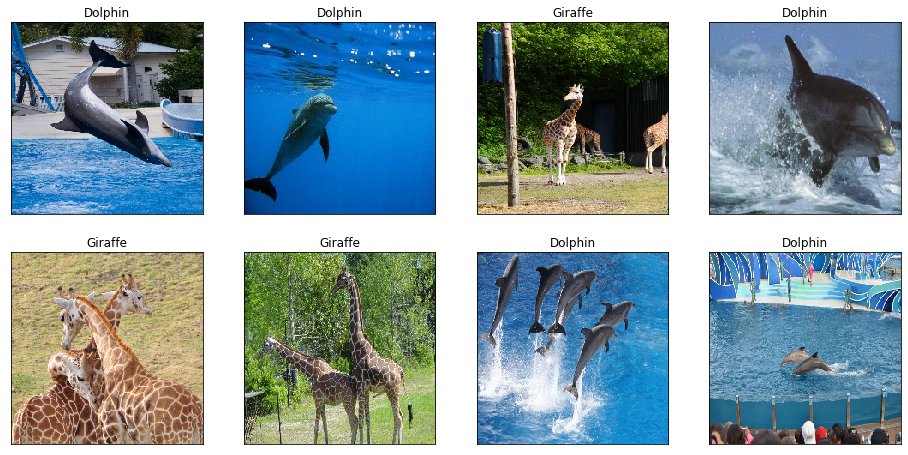

In [14]:
my_images.resize(width=224, height=224, inplace=True)
my_images.show(8, 4)

<h4>Summarize the Image Metadata in Newly Overwritten Image Table</h4>


Use `image_summary` to display the image metadata for the overwritten image table with standardized 224 x 224 images:

In [15]:
my_images.image_summary

jpg                    94
minWidth              224
maxWidth              224
minHeight             224
maxHeight             224
meanWidth             224
meanHeight            224
mean1stChannel    128.352
min1stChannel           0
max1stChannel         255
mean2ndChannel    124.451
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    97.7435
min3rdChannel           0
max3rdChannel         255
dtype: object

The table data shows that all 94 images in the original `my_images` table have been uniformly resized to standard 224 pixel by 224 pixel size. The resized table overwrites the original table image data because `inspace` was set to `True`.

<h3>Image Processing: Crop Images</h3>


<h4> Create Crops from Original Images, Inplace=False</h4>

The code below crops images in the table `my_images` and builds patches sized 100 x 100 pixels. The top left corner of each cropped image is located at `x=50`, `y=50` coordinate in the image pixel grid. The resulting cropped images are 100 x 100 pixels in size. Because `inplace=False`, the original data table is preserved. The cropped images are saved to a new table named `cropped_images`.

In [16]:
cropped_images = my_images.crop(x=50, y=50, width=100, height=100, inplace=False)

Now examine the new table `cropped_images` by displaying 8 random images in a table with 4 columns.

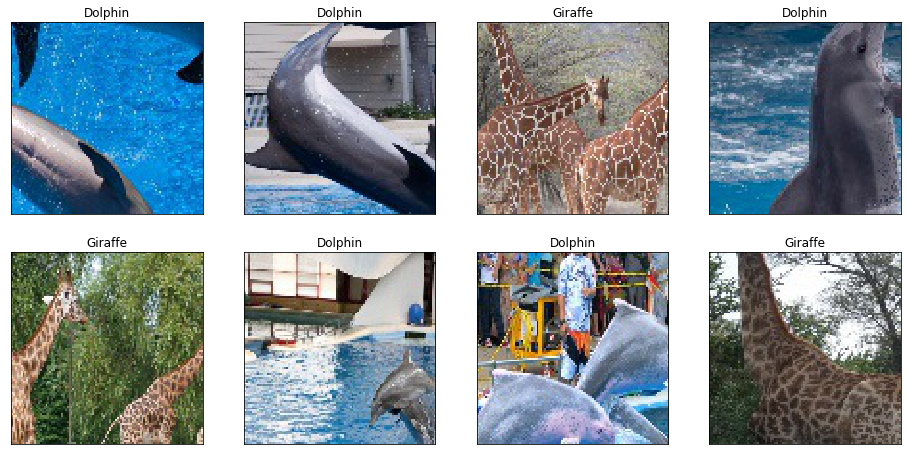

In [17]:
cropped_images.show(8, 4)

The cropped images appear to be uniformly resized. We can be sure of the image sizing by running an `image_summary` of the `cropped_images` table:

In [18]:
cropped_images.image_summary

jpg                    94
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel    119.778
min1stChannel           0
max1stChannel         255
mean2ndChannel    117.809
min2ndChannel           0
max2ndChannel         255
mean3rdChannel     100.59
min3rdChannel           0
max3rdChannel         255
dtype: object

The `image_summary` output above shows that all 94 images in the table were cropped, and that all of the cropped images in the table are 100 pixels by 100 pixels in dimension.

<h4> Extract Multiple Crops from Each Original Image</h4>

The following code shows how to use multiple crops from each image in the original image table to augment the training image data. The setting for `inplace` is `False`, so the original image table is not modified, and the augmented table (built from `my_images` is saved to a new name: `aug_images`. 

The top left corner of each new image patch is located at coordinates `x=0`,`y=0` on the image grid. The dimensions of each cropped patch are 112 x 112 pixels, with a rolling lens `step_size` of 56 pixels. The output images are 112 x 112 pixels.

In [19]:
aug_images = my_images.as_patches(x=0, y=0, width=112, height=112, step_size=56,
                                  output_width=112, output_height=112, inplace=False)

Visually inspect the patch images by displaying 15 images from `aug_images` in a table with 3 columns:

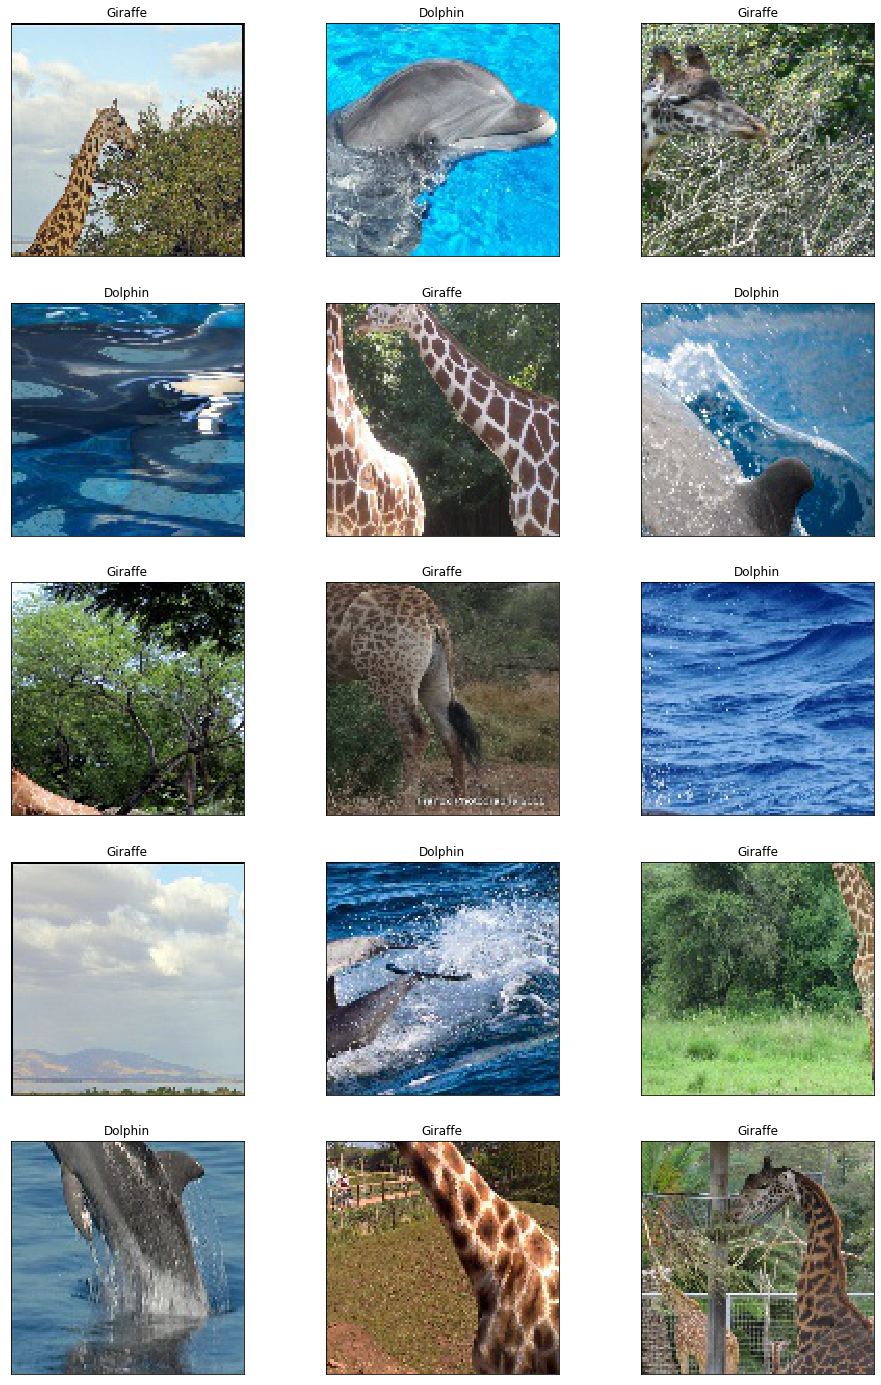

In [20]:
aug_images.show(15, 3, randomize=False)

You can get an idea of how the labeled images in the original data table `my_images` are distributed by performing a frequency analysis with `label_freq`:

In [21]:
my_images.label_freq

Frequency for IMAGEDATA_CRXKAL

         Level  Frequency
Dolphin      1         49
Giraffe      2         45

The original table `my_images` contains 49 labeled dolphin images and 45 labeled giraffe images.

You can also get an idea of the distribution of labeled images in the newly created augmented patch table named `aug_images` by performing a frequency analysis with `label_freq`:

In [22]:
aug_images.label_freq

Frequency for IMAGEDATA_Y7SM5K

         Level  Frequency
Dolphin      1        441
Giraffe      2        405

The augmented image table `aug_images` now contains 846 images, 9 times the number of images found in the original table named `my_images`. 


Submit `image_summary` to see metadata details about the augmented data table: 

In [23]:
aug_images.image_summary

jpg                   846
minWidth              112
maxWidth              112
minHeight             112
maxHeight             112
meanWidth             112
meanHeight            112
mean1stChannel    126.005
min1stChannel           0
max1stChannel         255
mean2ndChannel    122.797
min2ndChannel           0
max2ndChannel         255
mean3rdChannel     98.527
min3rdChannel           0
max3rdChannel         255
dtype: object

It is easy to see how using multiple patches can increase the quality of model training by augmenting the number of labeled images in the training data. Where the original `my_images` contained 94 labeled images, the image processed table `aug_images` contains 846 labeled images. 

#### Create Random Patches

Another way to use image processing to improve CNN model training data is to perform random augmentation using image patches.  This technique extracts multiple crops from each of the original images, and randomly adds into the table.

The following code generates random patches from `my_images` to form an augmented image table named `raug_images`. The setting `random_ratio` specifies the proportion of the generated patches to write to the output table. The upper left corner of image patches begins at image grid location `x=0`,`y=0`. Each patch is 112 pixels in height and width, the sliding patch lens uses a step size of 56 pixels, and the output patch images are 112 x 112 pixels.

Because `inplace=False`, the source table `my_images` is not modified, and changes are saved in the new table of random augmented images, `raug_images`.

In [24]:
raug_images = my_images.as_random_patches(random_ratio=0.5, 
                                          x=0, y=0, width=112, height=112, 
                                          step_size=56,
                                          output_width=112, output_height=112, 
                                          inplace=False)

You can view 15 images from the random augmented image table, and display them in a 3-column table using `show()`. 

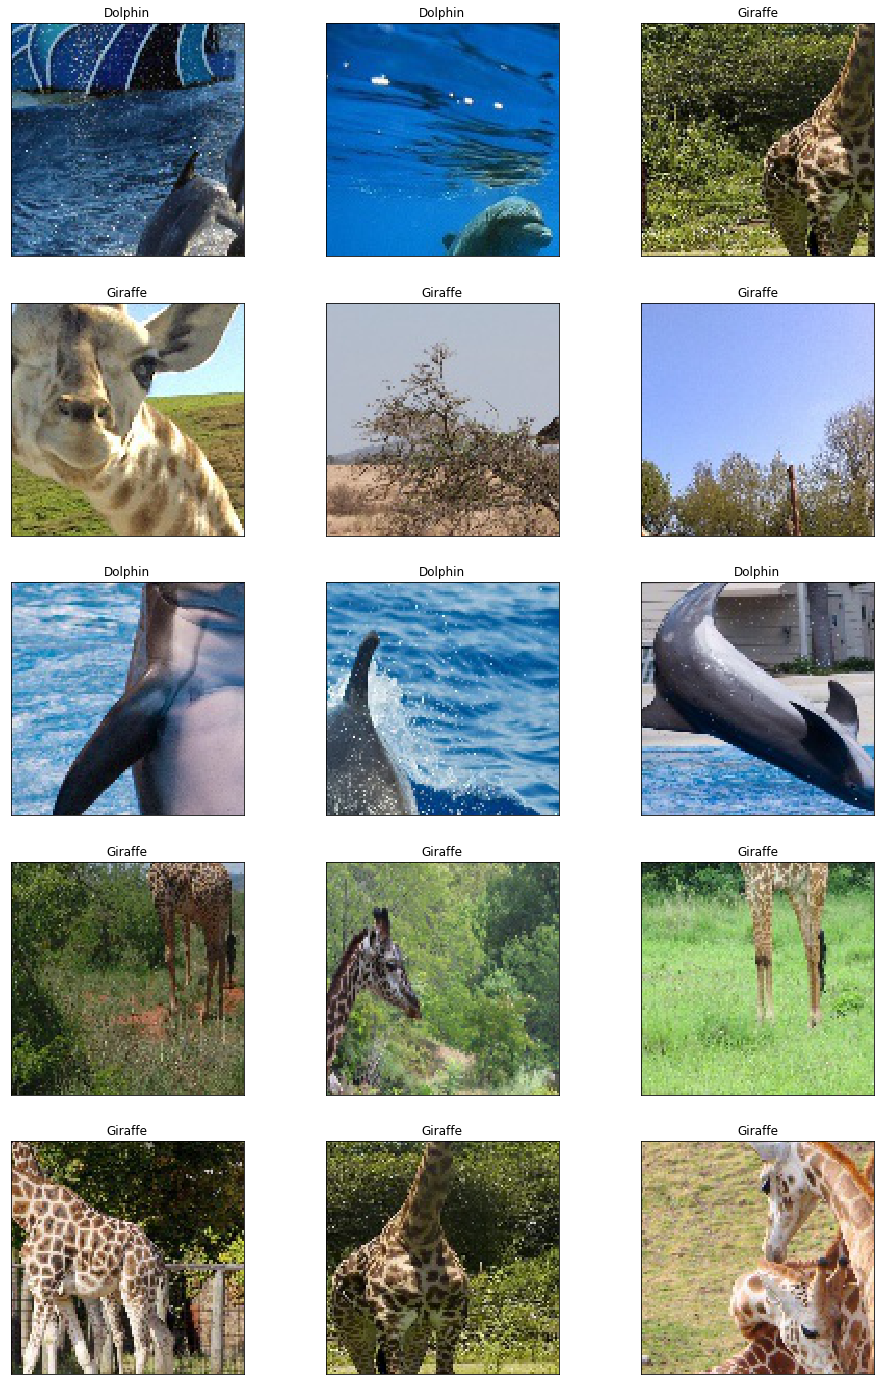

In [25]:
raug_images.show(15, 3, randomize=False)

<h4>Frequency Analysis of Original Image Table `my_images`</h4>

To compare how the labeled images are distributed in the original image table and the random augmented image table,  use `label_freq`. First, let's look at the original image table `my_images`:

In [26]:
my_images.label_freq

Frequency for IMAGEDATA_CRXKAL

         Level  Frequency
Dolphin      1         49
Giraffe      2         45

The table shows 49 dolphin images and 45 giraffe images, for a total of 94 images in the `my_images` collection.



<h4>Frequency Analysis and Summary of Random Patches Image Table `raug_images`</h4>

Now, let's look at how the images are distributed in the random augmented image table `raug_images`:

In [27]:
raug_images.label_freq

Frequency for IMAGEDATA_LIFKDH

         Level  Frequency
Dolphin      1        196
Giraffe      2        180

It is easy to see the large increase in the size of the image data: the number of images has more than quadrupled. The table shows 196 labeled dolphin images and 180 labeled giraffe images, for a total of 376 labeled images.

Use `image_summary` to view the metadata for the random augmented image table `raug_images`:

In [28]:
raug_images.image_summary

jpg                   376
minWidth              112
maxWidth              112
minHeight             112
maxHeight             112
meanWidth             112
meanHeight            112
mean1stChannel    125.265
min1stChannel           0
max1stChannel         255
mean2ndChannel    121.853
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    98.3497
min3rdChannel           0
max3rdChannel         255
dtype: object

<b>Note:</b> The only difference between augmenting the orignal image data table using `as_patches` versus using `as_random_patches` is that the `as_patches` technique keeps all of the image crops. The `as_random_patches` technique only keeps the fractional portion of patches specified in the `random_ratio` setting.